# Deploying functions 

In [3]:
#Reference
#https://docs.openfaas.com/tutorials/kubernetes-hpa/
!ssh ubuntu@172.17.141.197 "sudo kubectl port-forward -n openfaas svc/gateway 8080:8080 &"


Unable to listen on port 8080: Listeners failed to create with the following errors: [unable to create listener: Error listen tcp4 127.0.0.1:8080: bind: address already in use unable to create listener: Error listen tcp6 [::1]:8080: bind: address already in use]
error: unable to listen on any of the requested ports: [{8080 8080}]


In [13]:
#Deploy function and enable the function auto scaling by openfaas
!ssh ubuntu@172.17.141.197 "cd scalingsdp;faas deploy  -f scaling-aeneas-mqtt.yml  --env max_inflight=50 --annotation topic="aeneas" --label com.openfaas.scale.min=1 --label com.openfaas.scale.max=1"

Deploying: scaling-aeneas-mqtt.

Deployed. 202 Accepted.
URL: http://127.0.0.1:8080/function/scaling-aeneas-mqtt



In [59]:
#Deploy function and enable the function auto scaling by openfaas
!ssh ubuntu@172.17.141.197 "cd scalingsdp;faas deploy  -f scaling-aeneas-tocloud.yml --env max_inflight=50 --annotation topic="tocloud" --label com.openfaas.scale.min=1 --label com.openfaas.scale.max=1;faas deploy  -f getobject.yml --env max_inflight=50 --label com.openfaas.scale.min=1 --label com.openfaas.scale.max=1;faas deploy  -f pubrabbitmq.yml --env max_inflight=50 --label com.openfaas.scale.min=1 --label com.openfaas.scale.max=1"


Deploying: scaling-aeneas-tocloud.

Deployed. 202 Accepted.
URL: http://127.0.0.1:8080/function/scaling-aeneas-tocloud

Deploying: getobject.

Deployed. 202 Accepted.
URL: http://127.0.0.1:8080/function/getobject

Deploying: pubrabbitmq.

Deployed. 202 Accepted.
URL: http://127.0.0.1:8080/function/pubrabbitmq



In [51]:
!ssh ubuntu@172.17.141.197 "faas describe getobject"

Name:               getobject
Status:             Ready
Replicas:           1
Available Replicas: 1
Invocations:        94
Image:              shivupoojar/scalinggetobject:latest
Function Process:   python index.py
URL:                http://127.0.0.1:8080/function/getobject
Async URL:          http://127.0.0.1:8080/async-function/getobject
Labels:
 com.openfaas.scale.max: 1
 com.openfaas.scale.min: 1
 faas_function: getobject
 uid: 603978372
Annotations:
 prometheus.io.scrape: false
Requests:  CPU: 500m
 Memory: 128Mi


# Deploying Rabbitmq Connector 

In [7]:
# Deploying connector configurartion
!ssh ubuntu@172.17.141.197 "cd rabbitmq-connector/artifacts;sudo kubectl apply -f cf.yaml"

configmap/rabbitmq-connector-configmap unchanged


In [108]:
# Deploy connector
!ssh ubuntu@172.17.141.197 "cd rabbitmq-connector/artifacts;sudo kubectl apply -f configmap.yaml"

deployment.apps/rabbitmq-connector created


In [9]:
!ssh ubuntu@172.17.141.197 "sudo kubectl get po -n openfaas" 

NAME                                  READY   STATUS    RESTARTS       AGE
prometheus-7678c644d6-kkzz5           1/1     Running   1 (2d7h ago)   3d22h
nats-5b77986b8-48p2x                  1/1     Running   4 (158m ago)   36d
queue-worker-7d8668444f-tmq7b         1/1     Running   5 (158m ago)   21d
alertmanager-6cd7bd5c64-hrcrt         1/1     Running   4 (158m ago)   21d
basic-auth-plugin-78b958969c-tnpck    1/1     Running   4 (158m ago)   21d
gateway-bf4f5d6f7-4q7kn               2/2     Running   8 (158m ago)   21d
rabbitmq-connector-64cbd548f5-n5t6b   1/1     Running   2 (157m ago)   4d3h


# Deploying k8s HPA components 

In [36]:
!ssh ubuntu@172.17.141.197 "sudo kubectl autoscale deployment -n openfaas-fn scaling-aeneas-mqtt --cpu-percent=20 --min=1 --max=15;sudo kubectl autoscale deployment -n openfaas-fn scaling-aeneas-tocloud --cpu-percent=50 --min=1 --max=10;sudo kubectl autoscale deployment -n openfaas rabbitmq-connector --cpu-percent=50 --min=1 --max=10;sudo kubectl autoscale deployment -n openfaas-fn getobject --cpu-percent=50 --min=1 --max=10;sudo kubectl autoscale deployment -n openfaas-fn pubrabbitmq --cpu-percent=50 --min=1 --max=10"

horizontalpodautoscaler.autoscaling/scaling-aeneas-mqtt autoscaled
Error from server (AlreadyExists): horizontalpodautoscalers.autoscaling "scaling-aeneas-tocloud" already exists
Error from server (AlreadyExists): horizontalpodautoscalers.autoscaling "rabbitmq-connector" already exists
Error from server (AlreadyExists): horizontalpodautoscalers.autoscaling "getobject" already exists
Error from server (AlreadyExists): horizontalpodautoscalers.autoscaling "pubrabbitmq" already exists


In [45]:
#Check for the created HPA
!ssh ubuntu@172.17.141.197 "sudo kubectl get hpa -n openfaas-fn"

NAME                     REFERENCE                           TARGETS   MINPODS   MAXPODS   REPLICAS   AGE
aeneas                   Deployment/aeneas                   0%/20%    1         15        1          56m
pubrabbitmq              Deployment/pubrabbitmq              0%/50%    1         10        1          23h
scaling-aeneas-tocloud   Deployment/scaling-aeneas-tocloud   0%/50%    1         10        10         24h
scaling-aeneas-mqtt      Deployment/scaling-aeneas-mqtt      0%/20%    1         15        1          28m
getobject                Deployment/getobject                0%/50%    1         10        1          23h


In [12]:
#Check for the HPA settings
!ssh ubuntu@172.17.141.197 "sudo kubectl describe hpa/keda-hpa-rabbitmq-connector -n openfaas"

Error from server (NotFound): horizontalpodautoscalers.autoscaling "keda-hpa-rabbitmq-connector" not found


In [16]:
# Watch for every 5 seconds
!ssh ubuntu@172.17.141.197 "watch -n 5 "kubectl describe hpa/nodeinfo -n openfaas-fn""

^C


# Experiments 

In [103]:
import sys
import  datetime
import os
from minio import Minio
import csv
import json
import pandas as pd
import time
import subprocess
from subprocess import Popen, PIPE
import requests
from IPython.display import display

In [104]:
scenario = "k8s_k8s"
user=10
iteration=0.05
minio_host="172.17.141.197:9001"
bucket_name="aeneas-output"
PROMETHEUS = 'http://172.17.141.197:31022/'
time_locust=100


In [105]:
!rm input_data.csv
!touch input_data.csv
!echo "intime" > input_data.csv

In [106]:
!locust --headless -f rabbitmq_locust.py --host='127.0.0.1' -t 100s  --users 10 --spawn-rate 0.05

[2023-01-13 19:54:24,747] ubuntu/INFO/locust.main: Run time limit set to 100 seconds
[2023-01-13 19:54:24,748] ubuntu/INFO/locust.main: Starting Locust 2.14.0
Type     Name  # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------||-------|-------------|-------|-------|-------|-------|--------|-----------
--------||-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated       0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2023-01-13 19:54:24,751] ubuntu/INFO/locust.runners: Ramping to 10 users at a rate of 0.05 per second
[2023-01-13 19:54:24,771] ubuntu/INFO/pika.adapters.utils.connection_workflow: Pika version 1.3.1 connecting to ('172.17.141.197', 5672)
[2023-01-13 19:54:24,773] ubuntu/INFO/pika.adapters.utils.io_services_utils: Socket connected: <gevent._socket3.socket at 0xffffb3feebe0 object, fd=3, family=2, type=1, proto=6>
[2023-01-13 19:54:24,775] ubuntu/INFO/pika.adapters.utils.connection

Type     Name  # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------||-------|-------------|-------|-------|-------|-------|--------|-----------
BASIC_PUBLISH  test.message       7     0(0.00%) |      5       4       7      6 |    0.30        0.00
--------||-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated       7     0(0.00%) |      5       4       7      6 |    0.30        0.00

Type     Name  # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------||-------|-------------|-------|-------|-------|-------|--------|-----------
BASIC_PUBLISH  test.message       9     0(0.00%) |      5       4       7      6 |    0.30        0.00
--------||-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated       9     0(0.00%) |      5       4       7      6 |    0.30        0.00

Type     Name  # reqs      # fails |    Avg     Min     Max    Med |   req/s  failur

Type     Name  # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------||-------|-------------|-------|-------|-------|-------|--------|-----------
BASIC_PUBLISH  test.message      28     0(0.00%) |      5       4       7      6 |    0.60        0.00
--------||-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated      28     0(0.00%) |      5       4       7      6 |    0.60        0.00

Type     Name  # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------||-------|-------------|-------|-------|-------|-------|--------|-----------
BASIC_PUBLISH  test.message      31     0(0.00%) |      5       4       7      6 |    0.50        0.00
--------||-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated      31     0(0.00%) |      5       4       7      6 |    0.50        0.00

Type     Name  # reqs      # fails |    Avg     Min     Max    Med |   req/s  failur

[2023-01-13 19:56:04,006] ubuntu/INFO/locust.main: --run-time limit reached, shutting down
[2023-01-13 19:56:04,009] ubuntu/INFO/locust.main: Shutting down (exit code 0)
Type     Name  # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------||-------|-------------|-------|-------|-------|-------|--------|-----------
BASIC_PUBLISH  test.message      57     0(0.00%) |      5       4       7      6 |    0.60        0.00
--------||-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated      57     0(0.00%) |      5       4       7      6 |    0.60        0.00

Response time percentiles (approximated)
Type     Name      50%    66%    75%    80%    90%    95%    98%    99%  99.9% 99.99%   100% # reqs
--------||--------|------|------|------|------|------|------|------|------|------|------|------
BASIC_PUBLISH test.message        6      6      6      6      7      7      8      8      8      8      8     57
--------||--------|---

In [88]:
df= pd.read_csv('input_data.csv')
print(df)

                          intime
0   '2023-01-13 19:43:18.702992'
1   '2023-01-13 19:43:23.764632'
2   '2023-01-13 19:43:31.884488'
3   '2023-01-13 19:43:33.481861'
4   '2023-01-13 19:43:41.362846'
5   '2023-01-13 19:43:49.322174'
6   '2023-01-13 19:43:51.337261'
7   '2023-01-13 19:43:51.999503'
8   '2023-01-13 19:43:52.420171'
9   '2023-01-13 19:43:53.661628'
10  '2023-01-13 19:43:55.548201'
11  '2023-01-13 19:44:01.950966'
12  '2023-01-13 19:44:01.981780'
13  '2023-01-13 19:44:07.682727'
14  '2023-01-13 19:44:10.543708'
15  '2023-01-13 19:44:11.170065'
16  '2023-01-13 19:44:13.783768'
17  '2023-01-13 19:44:15.420376'
18  '2023-01-13 19:44:17.819581'
19  '2023-01-13 19:44:18.192294'
20  '2023-01-13 19:44:19.632861'
21  '2023-01-13 19:44:21.400160'
22  '2023-01-13 19:44:23.529973'
23  '2023-01-13 19:44:25.333485'
24  '2023-01-13 19:44:28.513269'
25  '2023-01-13 19:44:28.940065'
26  '2023-01-13 19:44:32.098628'
27  '2023-01-13 19:44:33.436138'
28  '2023-01-13 19:44:34.487835'
29  '2023-

In [89]:
#Minio Client
client = Minio(minio_host, access_key = "minio", secret_key ="minio123",secure=False)
# List objects from the bicket and notedown time  stamp  when they stored
objects = client.list_objects(bucket_name,recursive=True)
outtime = []
for obj in objects:
    outtime.append(obj.last_modified)#
    client.remove_object(bucket_name, obj.object_name)

In [90]:
df['outtime']= outtime
df['outtime']= pd.to_datetime(df['outtime'],errors='coerce').dt.tz_convert(None)
df['intime']= pd.to_datetime(df['intime'],errors='coerce')
#df =df.sort_values(by="outtime")
display(df)
print(df['outtime'].iloc[-1]-df['intime'].iloc[0])

,intime,outtime
0,2023-01-13 19:43:18.702992,2023-01-13 19:43:23.459
1,2023-01-13 19:43:23.764632,2023-01-13 19:43:28.452
2,2023-01-13 19:43:31.884488,2023-01-13 19:43:40.611
3,2023-01-13 19:43:33.481861,2023-01-13 19:43:43.405
4,2023-01-13 19:43:41.362846,2023-01-13 19:43:47.206
5,2023-01-13 19:43:49.322174,2023-01-13 19:44:02.383
6,2023-01-13 19:43:51.337261,2023-01-13 19:44:05.749
7,2023-01-13 19:43:51.999503,2023-01-13 19:44:06.971
8,2023-01-13 19:43:52.420171,2023-01-13 19:44:12.052
9,2023-01-13 19:43:53.661628,2023-01-13 19:44:14.812


0 days 00:02:04.608008


In [91]:
def get_function_execution_time(cmd):
    with Popen(cmd, stdout=PIPE, stderr=None, shell=True) as process:
        return (process.communicate()[0].decode("utf-8"))


In [92]:
#cmd1 = "sudo kubectl logs gateway-7b8d9dbb5b-rhnwl  -n openfaas -c gateway | grep getobject | cut -c 71-77 | tail -"
cmd1="ssh ubuntu@172.17.141.197 "+"sudo kubectl logs gateway-bf4f5d6f7-4q7kn  -n openfaas -c gateway  | grep /function/scaling-aeneas-mqtt | grep 200 | cut -c 93-97 | tail -"+str(len(outtime))
cmd2="ssh ubuntu@172.17.141.197 "+"sudo kubectl logs gateway-bf4f5d6f7-4q7kn -n openfaas -c gateway  | grep /function/scaling-aeneas-tocloud | cut -c 96-101 | tail -"+str(len(outtime))
cmd3="ssh ubuntu@172.17.141.197 "+"sudo kubectl logs gateway-bf4f5d6f7-4q7kn -n openfaas -c gateway  | grep /function/getobject | grep POST | cut -c 71-76  | tail -"+str(len(outtime))
cmd4="ssh ubuntu@172.17.141.197 "+"sudo kubectl logs gateway-bf4f5d6f7-4q7kn -n openfaas -c gateway  | grep /function/pubrabbitmq | grep POST | cut -c 73-78 | tail -"+str(len(outtime))
df['aeneas']=(get_function_execution_time(cmd1)).split("\n")[:-1]
#df['aeneas']=(pd.to_timedelta(df['aeneas'].astype(float), unit='s'))

df['tocloud']=(get_function_execution_time(cmd2)).split("\n")[:-1]
#df['tocloud']=(pd.to_timedelta(df['tocloud'].astype(float), unit='s'))

#df['getobject']=(get_function_execution_time(cmd3)).split("\n")[:-1]
df['pubrabbitmq']=((get_function_execution_time(cmd4)).split("\n")[:-1])
#df['pubrabbitmq']=(pd.to_timedelta(df['pubrabbitmq'].astype(float), unit='s'))
df

,intime,outtime,aeneas,tocloud,pubrabbitmq
0,2023-01-13 19:43:18.702992,2023-01-13 19:43:23.459,4.702,0.0412,0.0381
1,2023-01-13 19:43:23.764632,2023-01-13 19:43:28.452,4.630,0.0432,0.0433
2,2023-01-13 19:43:31.884488,2023-01-13 19:43:40.611,8.683,0.0400,0.0343
3,2023-01-13 19:43:33.481861,2023-01-13 19:43:43.405,9.871,0.0394,0.0341
4,2023-01-13 19:43:41.362846,2023-01-13 19:43:47.206,5.798,0.0444,0.0364
5,2023-01-13 19:43:49.322174,2023-01-13 19:44:02.383,8.682,0.0462,0.0416
6,2023-01-13 19:43:51.337261,2023-01-13 19:44:05.749,16.49,0.0485,0.0612
7,2023-01-13 19:43:51.999503,2023-01-13 19:44:06.971,11.39,0.0412,0.0416
8,2023-01-13 19:43:52.420171,2023-01-13 19:44:12.052,10.02,0.0412,0.0344
9,2023-01-13 19:43:53.661628,2023-01-13 19:44:14.812,7.085,0.0476,0.0484


In [118]:
#df =df.sort_values(by="outtime")
df['TPT']=(df['outtime']-df['intime'])
df['TPT']=df['TPT'].values.astype('datetime64[ns]')
df['TPT']= pd.to_datetime(df['TPT']).dt.strftime('%S.%f')
df['TPT']=df['TPT'].astype(float)
df['PT']= df['TPT'].round(decimals = 0)
df['FET'] = (df['aeneas']).astype(float) + (df['tocloud']).astype(float)
#df['MQ time']= ((df['TPT']).astype(float) - df['FET'])
df["scenario"]= ""+str(user)+"_"+str(iteration)+"_"+scenario
display(df)
#TPT: Total Processing Time
#FET: Function Execution Time
#CT: Communication Time
#print(df)
# #df =df.sort_values(by="outtime")
# df['TPT']=(df['outtime']-df['intime'])
# #print(df['TPT'])
# #df['aeneas']= pd.to_timedelta(df['aeneas'].astype(float) , unit='s')
# df['FET'] = df['aeneas'].astype(float) + df['tocloud'].astype(float)
# #df['FET'] = pd.to_timedelta(df['aeneas'].astype(float), unit='s') + pd.to_timedelta(df['tocloud'].astype(float) , unit='s')
# df['FET']= pd.to_timedelta(df['FET'], unit='s')
# df['MQ time']= (df['TPT']) - (df['FET'])
# df["scenario"]= ""+str(user)+"_"+str(iteration)+"_"+scenario
# display(df)
df.to_csv(""+str(user)+"_"+str(time_locust)+"_"+scenario+'.csv')

,intime,outtime,aeneas,tocloud,pubrabbitmq,TPT,PT,FET,scenario
0,2023-01-13 19:43:18.702992,2023-01-13 19:43:23.459,4.702,0.0412,0.0381,4.756008,5.0,4.7432,10_0.05_k8s_k8s
1,2023-01-13 19:43:23.764632,2023-01-13 19:43:28.452,4.630,0.0432,0.0433,4.687368,5.0,4.6732,10_0.05_k8s_k8s
2,2023-01-13 19:43:31.884488,2023-01-13 19:43:40.611,8.683,0.0400,0.0343,8.726512,9.0,8.7230,10_0.05_k8s_k8s
3,2023-01-13 19:43:33.481861,2023-01-13 19:43:43.405,9.871,0.0394,0.0341,9.923139,10.0,9.9104,10_0.05_k8s_k8s
4,2023-01-13 19:43:41.362846,2023-01-13 19:43:47.206,5.798,0.0444,0.0364,5.843154,6.0,5.8424,10_0.05_k8s_k8s
5,2023-01-13 19:43:49.322174,2023-01-13 19:44:02.383,8.682,0.0462,0.0416,13.060826,13.0,8.7282,10_0.05_k8s_k8s
6,2023-01-13 19:43:51.337261,2023-01-13 19:44:05.749,16.49,0.0485,0.0612,14.411739,14.0,16.5385,10_0.05_k8s_k8s
7,2023-01-13 19:43:51.999503,2023-01-13 19:44:06.971,11.39,0.0412,0.0416,14.971497,15.0,11.4312,10_0.05_k8s_k8s
8,2023-01-13 19:43:52.420171,2023-01-13 19:44:12.052,10.02,0.0412,0.0344,19.631829,20.0,10.0612,10_0.05_k8s_k8s
9,2023-01-13 19:43:53.661628,2023-01-13 19:44:14.812,7.085,0.0476,0.0484,21.150372,21.0,7.1326,10_0.05_k8s_k8s


,PT,frequency,pdf,cdf
0,5.0,6,0.150,0.150
1,6.0,4,0.100,0.250
2,7.0,2,0.050,0.300
3,8.0,5,0.125,0.425
4,9.0,3,0.075,0.500
5,10.0,2,0.050,0.550
6,12.0,1,0.025,0.575
7,13.0,1,0.025,0.600
8,14.0,1,0.025,0.625
9,15.0,1,0.025,0.650


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0, 0.5, 'CDF')

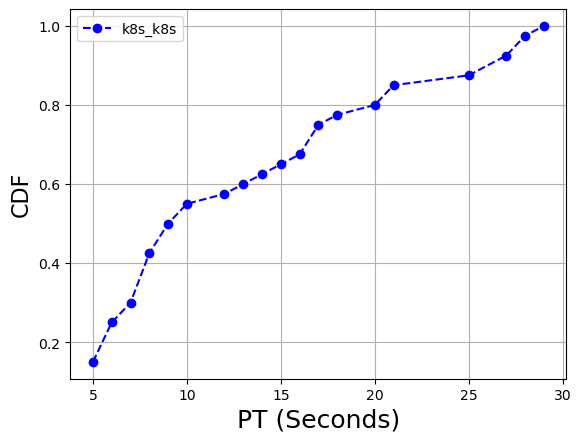

In [120]:
# Frequency
stats_df = df \
.groupby('PT') \
['PT'] \
.agg('count') \
.pipe(pd.DataFrame) \
.rename(columns = {'PT': 'frequency'})

# PDF
stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])
stats_df['cdf'] = stats_df['pdf'].cumsum()
stats_df = stats_df.reset_index()
display(stats_df)
stats_df.to_csv("stats_df_k8shpa_k8shpa.csv")
from matplotlib import pyplot as plt

plt.plot(stats_df['PT'],stats_df['cdf'],  linestyle='--', marker='o', color='b', label='k8s_k8s')
#plt.plot(df['user'],df['CT'],  linestyle='--', marker='*', color='r', label='Communication Time')
plt.grid()
plt.legend(loc='best')
plt.xlabel('PT (Seconds)', fontsize=18)
plt.ylabel('CDF', fontsize=16)

In [95]:
pre_url = PROMETHEUS + '/api/v1/query?query='
timestamp= pd.to_datetime(df['outtime'].iloc[-1], format='%Y-%m-%d %H:%M:%S')
time_interval = (time.mktime(timestamp.timetuple()))
#interval= int(df['TPT'].sum()) if int(df['TPT'].sum()) > 60  else 60
user=df.shape[0]

In [96]:
interval = (df.loc[user-1, 'outtime'] - df.loc[0, 'intime']).total_seconds()
interval= round(interval)

In [97]:
interval= round((df.loc[user-1, 'outtime'] - df.loc[0, 'intime']).total_seconds()) if round((df.loc[user-1, 'outtime'] - df.loc[0, 'intime']).total_seconds()) > 60  else 60
print(interval)

125


In [98]:
def getdataprometheus(url):
    headers= {"Accept": "application/json"}
    res = json.loads(requests.post(url=url, headers=headers).content.decode('utf8', 'ignore'))
    data=res.get('data').get('result')[0].get('value')[1]
    return data

In [99]:
user=df.shape[0]
metrics = {'workload_type':""+str(user)+"_"+str(time_locust)+"_"+scenario,'workload_size':user,'Workload TPT':(df.loc[user-1, 'outtime'] - df.loc[0, 'intime']).total_seconds(),'Average Workload TPT':df['TPT'].mean(),'Average FET':df['FET'].mean()}


In [100]:

#expr_namespace_cpu_requested = 'sum(node_namespace_pod_container:container_cpu_usage_seconds_total:sum_irate{namespace="openfaas-fn"})&time='+str(time_interval)
expr_namespace_cpu_used='sum(rate(container_cpu_usage_seconds_total{container_name!="POD",namespace="openfaas-fn"}['+str(interval)+'s]))&time='+str(time_interval)
metrics['CPU_used']=getdataprometheus(pre_url+expr_namespace_cpu_used)
expr_namespace_cpu_requested='sum(kube_pod_container_resource_requests{job="kube-state-metrics", namespace="openfaas-fn", resource="cpu"})&time='+str(time_interval)
metrics['CPU_requested']=getdataprometheus(pre_url+expr_namespace_cpu_requested)

expr_pod_cpu_rabbitmq_connector = 'sum(rate(container_cpu_usage_seconds_total{container_name!="POD",namespace="openfaas",pod=~"rabbitmq.*"}['+str(interval)+'s]))&time='+str(time_interval)
expr_pod_memory_rabbitmq_connector = 'sum(rate(container_memory_usage_bytes{container_name!="POD",namespace="openfaas",pod=~"rabbitmq.*"}['+str(interval)+'s]))&time='+str(time_interval)
metrics['CPU_rabbitmq_broker_used']=getdataprometheus(pre_url+expr_pod_cpu_rabbitmq_broker)
metrics['Memory_rabbitmq_broker_used']=getdataprometheus(pre_url+expr_pod_memory_rabbitmq_connector)

expr_pod_cpu_rabbitmq_connector_requested = 'sum(kube_pod_container_resource_requests{job="kube-state-metrics", namespace="openfaas", resource="cpu",pod=~"rabbitmq.*"})&time='+str(time_interval)
expr_pod_memory_rabbitmq_connector = 'sum(rate(container_memory_usage_bytes{container_name!="POD",namespace="openfaas",pod=~"rabbitmq.*"}['+str(interval)+'s]))&time='+str(time_interval)
metrics['CPU_rabbitmq_broker_requested']=getdataprometheus(pre_url+expr_pod_cpu_rabbitmq_connector_requested)

expr_pod_rabbitmq_function = 'sum(kube_pod_container_status_ready{namespace="openfaas",pod=~"rabbitmq.*"})&time='+str(time_interval)
metrics['pod_count_rabbitmq']=getdataprometheus(pre_url+expr_pod_rabbitmq_function)

expr_pod_aeneas_function = 'sum(kube_pod_container_status_ready{namespace="openfaas-fn",pod=~"scaling-aeneas-mqtt.*"})&time='+str(time_interval)
expr_pod_tocloud_function = 'sum(kube_pod_container_status_ready{namespace="openfaas-fn",pod=~"scaling-aeneas-tocloud.*"})&time='+str(time_interval)
expr_pod_getobject_function = 'sum(kube_pod_container_status_ready{namespace="openfaas-fn",pod=~"getobject.*"})&time='+str(time_interval)
print(pre_url+expr_pod_aeneas_function)
metrics['pod_count_aeneas']=getdataprometheus(pre_url+expr_pod_aeneas_function)
metrics['pod_count_tocloud']=getdataprometheus(pre_url+expr_pod_tocloud_function)
metrics['pod_count_getobject']=getdataprometheus(pre_url+expr_pod_getobject_function)

metrics


http://172.17.141.197:31022//api/v1/query?query=sum(kube_pod_container_status_ready{namespace="openfaas-fn",pod=~"scaling-aeneas-mqtt.*"})&time=1673639123.0


{'workload_type': '40_100_k8s_k8s',
 'workload_size': 40,
 'Workload TPT': 124.608008,
 'Average Workload TPT': 12.9865058,
 'Average FET': 13.099460000000002,
 'CPU_used': '4.072007372347675',
 'CPU_requested': '13.5',
 'CPU_rabbitmq_broker_used': '0.021599085256970022',
 'Memory_rabbitmq_broker_used': '491890.2409198615',
 'CPU_rabbitmq_broker_requested': '0.2',
 'pod_count_rabbitmq': '1',
 'pod_count_aeneas': '4',
 'pod_count_tocloud': '1',
 'pod_count_getobject': '1'}

In [101]:
df_metrics = pd.read_csv("k8shpa_k8shpa.csv")
df_metrics = df_metrics.append(metrics, ignore_index=True)

/tmp/ipykernel_8390/2758968194.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append(metrics, ignore_index=True)


In [102]:
df_metrics.to_csv("k8shpa_k8shpa.csv",index=False)
display(df_metrics)

,Average Workload TPT,Workload TPT,workload_size,workload_type,Average FET,pod_count_aeneas,pod_count_getobject,pod_count_tocloud,pod_count_connector,CPU_rabbitmq_broker,CPU_rabbitmq_broker_requested,CPU_rabbitmq_broker_used,CPU_requested,CPU_used,Memory_rabbitmq_broker,Memory_rabbitmq_broker_used,pod_count_rabbitmq
0,7.797256,105.956321,40,40_100_k8s_k8s,7.786122,4,1,1,NaN,NaN,0.2,0.021599,11.5,2.576263,NaN,211346.01804,1
1,12.986506,124.608008,40,40_100_k8s_k8s,13.099460,4,1,1,NaN,NaN,0.2,0.021599085256970022,13.5,4.072007372347675,NaN,491890.2409198615,1


In [54]:
#Pod Stats
#expr_pod_cpu_aeneas_function = 'sum(rate(container_cpu_usage_seconds_total{container_name!="POD",namespace="openfaas-fn",pod=~"aeneas.*"}['+str(interval)+'s]))&time='+str(time_interval)
#expr_pod_cpu_tocloud_function = 'sum(rate(container_cpu_usage_seconds_total{container_name!="POD",namespace="openfaas-fn",pod=~"scaling.*"}['+str(interval)+'s]))&time='+str(time_interval)
#expr_pod_cpu_rabbitmq_broker = 'sum(rate(container_cpu_usage_seconds_total{container_name!="POD",pod=~"rabbitmq.*"}['+str(interval)+'s]))&time='+str(time_interval)
# expr_pod_cpu_rabbitmq_connector = 'sum(rate(container_cpu_usage_seconds_total{container_name!="POD",namespace="openfaas",pod=~"rabbitmq.*"}['+str(interval)+'s]))&time='+str(time_interval)
# expr_pod_memory_rabbitmq_connector = 'sum(rate(container_memory_usage_bytes{container_name!="POD",namespace="openfaas",pod=~"rabbitmq.*"}['+str(interval)+'s]))&time='+str(time_interval)

# #expr_pod_cpu_functions_all = 'sum(rate(container_cpu_usage_seconds_total{container_name!="POD",namespace="openfaas-fn"}['+str(interval)+'s]))&time='+str(time_interval)
# #print(pre_url+expr_pod_cpu_rabbitmq_connector)
# #metrics['pod_cpu_aeneas_function']=getdataprometheus(pre_url+expr_pod_cpu_aeneas_function)
# #metrics['pod_cpu_tocloud_function']=getdataprometheus(pre_url+expr_pod_cpu_tocloud_function)
# metrics['pod_cpu_rabbitmq_broker']=getdataprometheus(pre_url+expr_pod_cpu_rabbitmq_broker)
# #metrics['pod_cpu_rabbitmq_connector']=getdataprometheus(pre_url+expr_pod_cpu_rabbitmq_connector)

# #metrics['pod_memory_rabbitmq_connector']=getdataprometheus(pre_url+expr_pod_memory_rabbitmq_connector)

# #metrics['pod_cpu_functions_all']=getdataprometheus(pre_url+expr_pod_cpu_functions_all)

# #expr_pod_aeneas_function = 'sum(kube_pod_container_status_ready{namespace="openfaas-fn",pod=~"aeneas.*"})'
# #expr_pod_tocloud_function = 'sum(kube_pod_container_status_ready{namespace="openfaas-fn",pod=~"scaling.*"})'
# #expr_pod_getobject_function = 'sum(kube_pod_container_status_ready{namespace="openfaas-fn",pod=~"getobject.*"})'
# expr_pod_rabbitmq_function = 'sum(kube_pod_container_status_ready{namespace="openfaas",pod=~"rabbitmq.*"})&time='+str(time_interval)
# metrics['pod_count_rabbitmq']=getdataprometheus(pre_url+expr_pod_rabbitmq_function)
# #metrics['pod_count_aeneas']=getdataprometheus(pre_url+expr_pod_aeneas_function)
# #metrics['pod_count_tocloud']=getdataprometheus(pre_url+expr_pod_tocloud_function)
# #metrics['pod_count_getobject']=getdataprometheus(pre_url+expr_pod_getobject_function)

#metrics['pod_aeneas_cpu_percent']=((int(metrics['pod_cpu_aeneas_function'])*1000)/int(metrics['pod_count_aeneas'])*100

http://172.17.141.197:31022//api/v1/query?query=sum(rate(container_cpu_usage_seconds_total{container_name!="POD",namespace="openfaas",pod=~"rabbitmq.*"}[106s]))&time=1673634589.0


IndexError: list index out of range

In [ ]:
df_metrics = pd.read_csv("k8shpa_k8shpa.csv")
df_metrics = df_metrics.append(metrics, ignore_index=True)

In [ ]:
df_metrics.to_csv("k8shpa_k8shpa.csv",index=False)

In [ ]:
display(df_metrics)

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0, 0.5, 'Throughput (rps)')

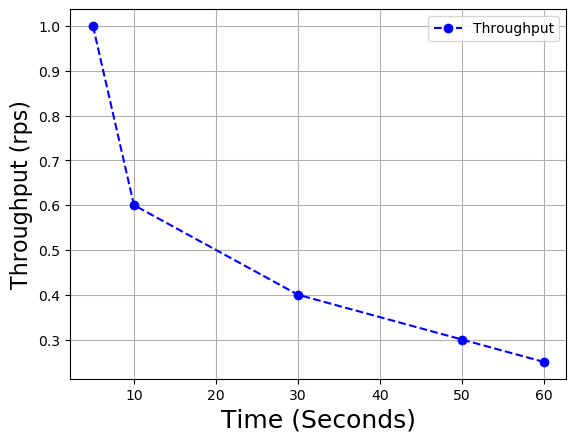

In [33]:
from matplotlib import pyplot as plt
df=pd.read_csv("throughput.csv")
plt.plot(df['Time'],df['Throughput'],  linestyle='--', marker='o', color='b', label='Throughput')
#plt.plot(df['user'],df['CT'],  linestyle='--', marker='*', color='r', label='Communication Time')
plt.grid()
plt.legend(loc='best')
plt.xlabel('Time (Seconds)', fontsize=18)
plt.ylabel('Throughput (rps)', fontsize=16)


In [116]:
!ssh ubuntu@172.17.141.197 "sudo kubectl get hpa -n openfaas-fn"

No resources found in openfaas-fn namespace.


In [117]:
!ssh ubuntu@172.17.141.197 "sudo kubectl delete hpa/rabbitmq-connector   -n openfaas"

horizontalpodautoscaler.autoscaling "rabbitmq-connector" deleted
